In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [9]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [2]:
import pandas as pd
def getData(filename):
    chunksize = 1200000
    flag =1
    for data in pd.read_csv(filename, sep=",", chunksize=chunksize):
        while flag<2 and chunksize < 1200000:
            print(data)
        flag+=1
    print(data.head())
    print(list(data.columns.values))
    print(type(data))
    
    return data

In [3]:
import random
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [4]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [5]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.9
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

In [6]:
X_train, y_train, X_test, y_test = split_data(dataset)

# Call the Encoder pkl file

In [7]:
import pickle

# Load the encoder model from the saved file
with open("Encoder.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [8]:
encoded_X = pd.DataFrame(encoder.predict(X))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



60/60 [==============================] - 0s 1ms/step


# tune the Encoder file

In [10]:
# train the model with random parameter

# Preparing the regressor and fitting data with some parameters
import xgboost


xg_reg = xgboost.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 1, 
                          learning_rate = 0.3,
                          max_depth = 15, 
                          alpha = 10, 
                          n_estimators = 100, 
                          verbose=1, 
                          min_child_weight = 1, 
                          colsample_bylevel = 1, 
                          reg_alpha = 2) 

xg_reg.fit(encoded_X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Finding mean absolute error
preds = xg_reg.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.6948974224092583

In [13]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(encoded_X)
target_train_tunned = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(encoded_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,1e-4,1e-3,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.04,0.08,0.12,0.20, 0.24, 0.30, 0.38, 0.42, 0.48, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20,25,30,35,40]),
            'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    model = xgboost.XGBRegressor(**param)  
        
    model.fit(train_X,train_Y,eval_set=[(valid_X,valid_Y)],early_stopping_rounds=100,verbose=False)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [14]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-02-06 23:38:56,973] A new study created in memory with name: XG_tune


In [15]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-06 23:39:14,911] Trial 0 finished with value: 0.8836438858800129 and parameters: {'lambda': 1.319357935099395, 'alpha': 1.7850984372336263, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.48, 'n_estimators': 156, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 167}. Best is trial 0 with value: 0.8836438858800129.


19229


[I 2024-02-06 23:39:30,493] Trial 1 finished with value: 0.8682206135987693 and parameters: {'lambda': 0.0027980722893795854, 'alpha': 1.7491994487902052, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.5, 'n_estimators': 296, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 215}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:39:48,429] Trial 2 finished with value: 1.149044299833649 and parameters: {'lambda': 0.01864251825241687, 'alpha': 0.1753631874282531, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 189, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 61}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:39:49,018] Trial 3 finished with value: 1.2619069882279297 and parameters: {'lambda': 0.002703838446422212, 'alpha': 0.0021445550122645243, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 0.6, 'learning_rate': 0.9, 'n_estimators': 4, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 252}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:39:59,611] Trial 4 finished with value: 0.9921060924123034 and parameters: {'lambda': 0.0017750996256084785, 'alpha': 0.05896156600200979, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.4, 'learning_rate': 0.5, 'n_estimators': 247, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 154}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:40:08,887] Trial 5 finished with value: 0.9094780368053426 and parameters: {'lambda': 0.027810204625230008, 'alpha': 1.4431009932228358, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'subsample': 0.6, 'learning_rate': 0.3, 'n_estimators': 206, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 75}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:40:20,140] Trial 6 finished with value: 1.504416441978174 and parameters: {'lambda': 0.0013400662791432589, 'alpha': 0.009736605773325014, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 39, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 48}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:40:25,173] Trial 7 finished with value: 0.9369942765077811 and parameters: {'lambda': 0.008884623080819025, 'alpha': 2.193979716793846, 'colsample_bytree': 0.4, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 49, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 60}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:40:45,636] Trial 8 finished with value: 1.3233375381807175 and parameters: {'lambda': 0.9836142537731906, 'alpha': 0.5378302771337908, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.004, 'n_estimators': 278, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 65}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:40:58,899] Trial 9 finished with value: 1.7066187527406742 and parameters: {'lambda': 0.7702401020877467, 'alpha': 0.014025957118045, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 281, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 174}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:41:03,999] Trial 10 finished with value: 1.5810071861968966 and parameters: {'lambda': 0.12541297954406366, 'alpha': 9.450281927857997, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 0.5, 'learning_rate': 0.005, 'n_estimators': 108, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 298}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:41:10,158] Trial 11 finished with value: 0.9110525343269753 and parameters: {'lambda': 7.526906879820351, 'alpha': 9.943253219555883, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.5, 'n_estimators': 123, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 207}. Best is trial 1 with value: 0.8682206135987693.


19229


[I 2024-02-06 23:41:22,030] Trial 12 finished with value: 0.8611241843824754 and parameters: {'lambda': 0.21508278643729706, 'alpha': 0.7223729563033559, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.24, 'n_estimators': 176, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 219}. Best is trial 12 with value: 0.8611241843824754.


19229


[I 2024-02-06 23:41:35,516] Trial 13 finished with value: 0.8700915172930918 and parameters: {'lambda': 0.1364843027289271, 'alpha': 0.24189343711229017, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.24, 'n_estimators': 227, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 224}. Best is trial 12 with value: 0.8611241843824754.


19229


[I 2024-02-06 23:41:45,369] Trial 14 finished with value: 1.714638396614805 and parameters: {'lambda': 0.3200983840646216, 'alpha': 0.6953582147558128, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 1e-05, 'n_estimators': 174, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 274}. Best is trial 12 with value: 0.8611241843824754.


19229


[I 2024-02-06 23:42:08,954] Trial 15 finished with value: 0.8267175364806437 and parameters: {'lambda': 0.050149477554562255, 'alpha': 0.0544290903163187, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.38, 'n_estimators': 298, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 119}. Best is trial 15 with value: 0.8267175364806437.


19229


[I 2024-02-06 23:42:18,075] Trial 16 finished with value: 0.8438145233994774 and parameters: {'lambda': 0.03575929502981798, 'alpha': 0.03374129379907601, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.38, 'n_estimators': 104, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 108}. Best is trial 15 with value: 0.8267175364806437.


19229


[I 2024-02-06 23:42:26,750] Trial 17 finished with value: 0.8259250618389486 and parameters: {'lambda': 0.017436883358775516, 'alpha': 0.042264896643539135, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 90, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 107}. Best is trial 17 with value: 0.8259250618389486.


19229


[I 2024-02-06 23:42:33,225] Trial 18 finished with value: 0.8482677846229856 and parameters: {'lambda': 0.006101484306761713, 'alpha': 0.008353910436861707, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 69, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 124}. Best is trial 17 with value: 0.8259250618389486.


19229


[I 2024-02-06 23:43:12,375] Trial 19 finished with value: 0.8738196957252004 and parameters: {'lambda': 0.039245855758093605, 'alpha': 0.0016356967060370167, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.8, 'n_estimators': 137, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 7}. Best is trial 17 with value: 0.8259250618389486.


19229


[I 2024-02-06 23:43:16,852] Trial 20 finished with value: 0.9360753493808771 and parameters: {'lambda': 0.06961000746120173, 'alpha': 0.028952835776188787, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.5, 'learning_rate': 0.38, 'n_estimators': 86, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 117}. Best is trial 17 with value: 0.8259250618389486.


19229


[I 2024-02-06 23:43:26,160] Trial 21 finished with value: 0.8217601721359594 and parameters: {'lambda': 0.011595939367501527, 'alpha': 0.06624805971271011, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 96, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 107}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:43:28,550] Trial 22 finished with value: 0.9701184165873782 and parameters: {'lambda': 0.011327132649977622, 'alpha': 0.11277776607762983, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 85, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 105}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:43:32,383] Trial 23 finished with value: 1.634186085601252 and parameters: {'lambda': 0.007823185986905038, 'alpha': 0.06423570486424275, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.007, 'n_estimators': 23, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 136}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:53:55,230] Trial 24 finished with value: 0.8280564275510108 and parameters: {'lambda': 0.01748927607592883, 'alpha': 0.00404719274790523, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.12, 'n_estimators': 147, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 90}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:54:01,009] Trial 25 finished with value: 1.4616720936551184 and parameters: {'lambda': 0.057976422510014065, 'alpha': 0.03097360253301284, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 67, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 144}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:55:04,124] Trial 26 finished with value: 1.1150808378242716 and parameters: {'lambda': 0.005065115637758137, 'alpha': 0.2065868995885235, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 119, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 10}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:55:21,972] Trial 27 finished with value: 0.8312283791246642 and parameters: {'lambda': 0.015646960253574458, 'alpha': 0.017706272210461088, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.2, 'n_estimators': 250, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 88}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:55:35,192] Trial 28 finished with value: 1.4415206544527839 and parameters: {'lambda': 0.003752895773761177, 'alpha': 0.059255812157568415, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'n_estimators': 92, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 35}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:55:45,961] Trial 29 finished with value: 0.9526550633880471 and parameters: {'lambda': 0.4870455583157678, 'alpha': 0.09639664943343494, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.7, 'n_estimators': 154, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 183}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:55:51,474] Trial 30 finished with value: 1.6327351514656685 and parameters: {'lambda': 0.0668709488096602, 'alpha': 0.0056479436597925824, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 58, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 167}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:04,627] Trial 31 finished with value: 0.831663879072699 and parameters: {'lambda': 0.01949139411324719, 'alpha': 0.0035752683581725627, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.12, 'n_estimators': 138, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 88}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:19,420] Trial 32 finished with value: 0.8632308922944776 and parameters: {'lambda': 0.028547563864970132, 'alpha': 0.004703327273114603, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 140, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 95}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:32,271] Trial 33 finished with value: 0.8681057309384574 and parameters: {'lambda': 2.3336939693988685, 'alpha': 0.001030228263466982, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 167, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 137}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:37,307] Trial 34 finished with value: 1.0245657920583806 and parameters: {'lambda': 0.010819941744364481, 'alpha': 0.018508548067285645, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 1.0, 'n_estimators': 199, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 121}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:51,522] Trial 35 finished with value: 0.9057821048295494 and parameters: {'lambda': 0.017811919888699318, 'alpha': 0.38999220773237864, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 219, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 82}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:56:58,237] Trial 36 finished with value: 1.6199900440135917 and parameters: {'lambda': 0.0035327460433128175, 'alpha': 0.04487083340136972, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.002, 'n_estimators': 118, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 107}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:57:04,885] Trial 37 finished with value: 1.7012308900271609 and parameters: {'lambda': 0.0020575277226804814, 'alpha': 0.11998777572102853, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 21, 'max_depth': 40, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:57:15,702] Trial 38 finished with value: 0.9656838860200614 and parameters: {'lambda': 0.04683023710747106, 'alpha': 0.0022979821819232842, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.4, 'learning_rate': 0.48, 'n_estimators': 297, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 160}. Best is trial 21 with value: 0.8217601721359594.


19229


[I 2024-02-06 23:57:28,257] Trial 39 finished with value: 0.8118384433362955 and parameters: {'lambda': 0.023487397136393945, 'alpha': 0.013153694381634096, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 77, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 69}. Best is trial 39 with value: 0.8118384433362955.


19229


[I 2024-02-06 23:57:37,416] Trial 40 finished with value: 1.688000565690105 and parameters: {'lambda': 0.0936835934047644, 'alpha': 0.011418603881646998, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 40, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 51}. Best is trial 39 with value: 0.8118384433362955.


19229


[I 2024-02-06 23:57:51,164] Trial 41 finished with value: 1.6663666838906261 and parameters: {'lambda': 0.02602287034454229, 'alpha': 0.022789275045240986, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 73, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 63}. Best is trial 39 with value: 0.8118384433362955.


19229


[I 2024-02-06 23:58:07,487] Trial 42 finished with value: 0.8076852835553825 and parameters: {'lambda': 0.013259770212515187, 'alpha': 0.007409856571870373, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 96, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 74}. Best is trial 42 with value: 0.8076852835553825.


19229


[I 2024-02-06 23:58:25,222] Trial 43 finished with value: 0.7980863144919844 and parameters: {'lambda': 0.010438547734936132, 'alpha': 0.008190188937292266, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 103, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 70}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-06 23:58:51,835] Trial 44 finished with value: 1.6445685753838941 and parameters: {'lambda': 0.0012671816948530393, 'alpha': 0.006759016481960976, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 95, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-06 23:59:09,692] Trial 45 finished with value: 0.8048384850981323 and parameters: {'lambda': 0.005885067281564499, 'alpha': 0.012585889964895592, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 104, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 72}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-06 23:59:21,586] Trial 46 finished with value: 1.655568289641465 and parameters: {'lambda': 0.005618890986187312, 'alpha': 0.0135217792385083, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 107, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 74}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-06 23:59:54,481] Trial 47 finished with value: 1.6540821061329498 and parameters: {'lambda': 0.0024936002575892797, 'alpha': 0.009440286712022641, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 75, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 24}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-07 00:00:08,181] Trial 48 finished with value: 1.6760446068723411 and parameters: {'lambda': 0.009901207064886845, 'alpha': 0.0028409126286175713, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 55, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 51}. Best is trial 43 with value: 0.7980863144919844.


19229


[I 2024-02-07 00:00:28,899] Trial 49 finished with value: 0.7976721182784099 and parameters: {'lambda': 0.0039561668230410785, 'alpha': 0.0077742125264134675, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 126, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 69}. Best is trial 49 with value: 0.7976721182784099.


19229


[I 2024-02-07 00:00:46,583] Trial 50 finished with value: 0.8096870566711548 and parameters: {'lambda': 0.0010544341138840538, 'alpha': 0.007303126981396155, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 126, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 65}. Best is trial 49 with value: 0.7976721182784099.


19229


[I 2024-02-07 00:01:02,955] Trial 51 finished with value: 1.6399254107154149 and parameters: {'lambda': 0.001362987793923046, 'alpha': 0.0073007870614151356, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 131, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 74}. Best is trial 49 with value: 0.7976721182784099.


19229


[I 2024-02-07 00:01:20,304] Trial 52 finished with value: 0.9213134478244397 and parameters: {'lambda': 0.003486409411146925, 'alpha': 0.0014226771577653887, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 114, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 64}. Best is trial 49 with value: 0.7976721182784099.


19229


[I 2024-02-07 00:02:06,203] Trial 53 finished with value: 0.7769696146594712 and parameters: {'lambda': 0.001789766265614667, 'alpha': 0.012637127367822146, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 127, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 53 with value: 0.7769696146594712.


19229


[I 2024-02-07 00:02:30,547] Trial 54 finished with value: 0.8009118117251777 and parameters: {'lambda': 0.0010257650717682306, 'alpha': 0.0033036220083272724, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 128, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 46}. Best is trial 53 with value: 0.7769696146594712.


19229


[I 2024-02-07 00:03:08,957] Trial 55 finished with value: 0.8161911739266402 and parameters: {'lambda': 0.0017384636975264598, 'alpha': 0.0027724588829544385, 'colsample_bytree': 0.4, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 160, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 20}. Best is trial 53 with value: 0.7769696146594712.


19229


[I 2024-02-07 00:03:27,598] Trial 56 finished with value: 0.8034883327560087 and parameters: {'lambda': 0.0026063297928613704, 'alpha': 0.0049375704100817, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 103, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 48}. Best is trial 53 with value: 0.7769696146594712.


19229


[I 2024-02-07 00:03:46,186] Trial 57 finished with value: 0.7975644196830064 and parameters: {'lambda': 0.0023773811002903667, 'alpha': 0.004707811791491884, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 106, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 53 with value: 0.7769696146594712.


19229


[I 2024-02-07 00:06:30,370] Trial 58 finished with value: 0.7543914306394872 and parameters: {'lambda': 0.0018779219929175805, 'alpha': 0.0037227986174478366, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 179, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:10:59,735] Trial 59 finished with value: 1.5422844037330679 and parameters: {'lambda': 0.0017438172880675175, 'alpha': 0.0016674221825397919, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 181, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:11:26,087] Trial 60 finished with value: 1.5862692912126197 and parameters: {'lambda': 0.004417461628040066, 'alpha': 0.003112479259510521, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 189, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:11:44,968] Trial 61 finished with value: 0.8065649361344169 and parameters: {'lambda': 0.002544335272339066, 'alpha': 0.004666208907816803, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 128, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 43}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:12:40,863] Trial 62 finished with value: 0.7995070098842686 and parameters: {'lambda': 0.0010538744186140224, 'alpha': 0.0019602493180281176, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 146, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:13:01,151] Trial 63 finished with value: 1.6191143960921515 and parameters: {'lambda': 0.0010538961085781713, 'alpha': 0.001073244922977505, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 148, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:14:11,938] Trial 64 finished with value: 0.7992325597090093 and parameters: {'lambda': 0.0016091602184443291, 'alpha': 0.002058353837774289, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 163, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:15:02,277] Trial 65 finished with value: 0.8050363170027297 and parameters: {'lambda': 0.001801436238825085, 'alpha': 0.0020136729823638424, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 165, 'max_depth': 30, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:16:00,644] Trial 66 finished with value: 1.604377580684658 and parameters: {'lambda': 0.0014870573344054102, 'alpha': 0.002234634228509267, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 145, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:16:06,135] Trial 67 finished with value: 1.0590577114899817 and parameters: {'lambda': 0.007815559367493483, 'alpha': 0.0014041257455675786, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.9, 'n_estimators': 185, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:16:16,236] Trial 68 finished with value: 1.706990001911963 and parameters: {'lambda': 0.0031938896633074633, 'alpha': 0.00550847223056869, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.0001, 'n_estimators': 157, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:17:23,408] Trial 69 finished with value: 1.2747108134100544 and parameters: {'lambda': 0.0021481337682239397, 'alpha': 0.018608953388815536, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.004, 'n_estimators': 171, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:17:38,906] Trial 70 finished with value: 1.1136233284368153 and parameters: {'lambda': 0.0042458535277682535, 'alpha': 6.030646865617103, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 204, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 26}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:17:51,045] Trial 71 finished with value: 1.6496971637015223 and parameters: {'lambda': 0.001058950114710847, 'alpha': 0.003887861916671153, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 115, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 55}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:18:09,875] Trial 72 finished with value: 1.6288656805661275 and parameters: {'lambda': 0.001414587242457561, 'alpha': 0.0036402228135137106, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 136, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 43}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:20:02,777] Trial 73 finished with value: 1.6044669651602042 and parameters: {'lambda': 0.002905828931576225, 'alpha': 0.0020695994949238195, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 127, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:20:27,584] Trial 74 finished with value: 0.8224951672394922 and parameters: {'lambda': 0.002118604549906324, 'alpha': 0.009860257884823937, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 158, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:02,410] Trial 75 finished with value: 1.2771435013191335 and parameters: {'lambda': 0.00683247935854546, 'alpha': 0.002883585938100173, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.005, 'n_estimators': 142, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:05,646] Trial 76 finished with value: 0.9366372197572838 and parameters: {'lambda': 0.001002413119976996, 'alpha': 0.005926062304436947, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.3, 'n_estimators': 114, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:14,822] Trial 77 finished with value: 1.6677991673989654 and parameters: {'lambda': 0.001566141032850184, 'alpha': 0.0017437224337214542, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 82, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 55}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:29,419] Trial 78 finished with value: 0.8939084597998435 and parameters: {'lambda': 0.002208344065119758, 'alpha': 0.0043251165796886655, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.5, 'n_estimators': 151, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:39,010] Trial 79 finished with value: 1.714557268112546 and parameters: {'lambda': 0.004136638803372903, 'alpha': 0.0013716315370767215, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 1e-05, 'n_estimators': 176, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 188}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:21:55,773] Trial 80 finished with value: 1.61783258693875 and parameters: {'lambda': 9.563715068835341, 'alpha': 0.0025069612581882753, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 195, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:22:16,327] Trial 81 finished with value: 0.8022912245500387 and parameters: {'lambda': 0.0026921932742903667, 'alpha': 0.005136152835360087, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 121, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 48}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:22:39,867] Trial 82 finished with value: 0.7987596743971023 and parameters: {'lambda': 0.003135486786710407, 'alpha': 0.0034434671300658066, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 133, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 43}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:23:01,240] Trial 83 finished with value: 1.6202371334334023 and parameters: {'lambda': 0.0012514293039743716, 'alpha': 0.0036004387216084805, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 138, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 24}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:23:30,760] Trial 84 finished with value: 0.8023680487716933 and parameters: {'lambda': 0.004677753212265787, 'alpha': 0.003269624714595379, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 220, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 57}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:23:45,042] Trial 85 finished with value: 1.3249276708382403 and parameters: {'lambda': 0.0033537757211859957, 'alpha': 0.008688079870338629, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.007, 'n_estimators': 133, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 82}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:23:56,607] Trial 86 finished with value: 1.2921169902711844 and parameters: {'lambda': 0.0018625022478296741, 'alpha': 0.0011956129551514121, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 101, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:24:03,149] Trial 87 finished with value: 0.9269393699914853 and parameters: {'lambda': 3.725701176877952, 'alpha': 0.0063699772313217246, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.24, 'n_estimators': 123, 'max_depth': 30, 'random_state': 2020, 'min_child_weight': 231}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:24:55,409] Trial 88 finished with value: 0.9441689015573189 and parameters: {'lambda': 0.0014542171499215344, 'alpha': 0.0018775452005164847, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.8, 'n_estimators': 109, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:25:05,364] Trial 89 finished with value: 0.8347158334689463 and parameters: {'lambda': 0.003036132782766771, 'alpha': 0.010262119573320697, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.3, 'n_estimators': 167, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 98}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:25:11,901] Trial 90 finished with value: 0.8706209979986811 and parameters: {'lambda': 0.17789019659561944, 'alpha': 0.01603164665548432, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 0.5, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 30}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:25:32,554] Trial 91 finished with value: 0.8031192127435236 and parameters: {'lambda': 0.002492519540646901, 'alpha': 0.005712719073413036, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 120, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 46}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:26:17,072] Trial 92 finished with value: 1.1934406587489712 and parameters: {'lambda': 0.0013086094946265566, 'alpha': 0.004866008163079683, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 112, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:26:34,470] Trial 93 finished with value: 1.6373921724704619 and parameters: {'lambda': 0.0021321926928526184, 'alpha': 0.0026085972183738384, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 129, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 61}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:26:39,624] Trial 94 finished with value: 0.9447047511594481 and parameters: {'lambda': 0.0016892813600556758, 'alpha': 0.025191620583608416, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 100, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 299}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:26:56,066] Trial 95 finished with value: 0.855733781233116 and parameters: {'lambda': 0.006699318486056758, 'alpha': 0.004012758935867095, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 90, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:27:15,375] Trial 96 finished with value: 0.9561887610559086 and parameters: {'lambda': 0.00277860946326453, 'alpha': 0.008508267409274756, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.7, 'n_estimators': 120, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 49}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:27:19,681] Trial 97 finished with value: 1.4848230673423815 and parameters: {'lambda': 0.005012344109582298, 'alpha': 0.0024765238066834306, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.006, 'n_estimators': 142, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 80}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:27:25,586] Trial 98 finished with value: 0.9401401450316739 and parameters: {'lambda': 0.0035632672363972227, 'alpha': 0.007713767450167022, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.42, 'n_estimators': 133, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 58 with value: 0.7543914306394872.


19229


[I 2024-02-07 00:27:58,294] Trial 99 finished with value: 1.0100604571513276 and parameters: {'lambda': 0.0011422144723222739, 'alpha': 0.003171149447163504, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 1.0, 'n_estimators': 180, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 58 with value: 0.7543914306394872.


19229
Number of finished trials: 100
Best trial: {'lambda': 0.0018779219929175805, 'alpha': 0.0037227986174478366, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 179, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 2}


In [17]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["lambda", "alpha","colsample_bytree","colsample_bylevel","subsample","learning_rate","n_estimators","max_depth","random_state","min_child_weight"])
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
fig_study.show()

<Figure size 640x480 with 0 Axes>

In [18]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7543914306394872
  Params: 
    lambda: 0.0018779219929175805
    alpha: 0.0037227986174478366
    colsample_bytree: 0.9
    colsample_bylevel: 0.6
    subsample: 0.7
    learning_rate: 0.3
    n_estimators: 179
    max_depth: 35
    random_state: 2020
    min_child_weight: 2


# process the whole data

In [19]:
filename_2 = '../shot_listed_dataset/Cover_type_whole_genuine_dataset_normalization.csv'
dataset_2=getData(filename_2).values.tolist()
random.shuffle(dataset_2)

dataset_2=pd.DataFrame(dataset_2) #from dataset_list to dataset_dataframe after suffling
print(dataset_2)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.672888  0.141667  0.045455                          0.184681   
1   0.671332  0.155556  0.030303                          0.151754   
2   0.726801  0.386111  0.136364                          0.191840   
3   0.721877  0.430556  0.272727                          0.173228   
4   0.672628  0.125000  0.030303                          0.109520   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.000000                         0.071659   
1                       -0.009983                         0.054798   
2                        0.108153                         0.446817   
3                        0.196339                         0.434172   
4                       -0.001664                         0.054939   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.870079        0.913386       0.582677   
1       0.866142        0.925197       0.594488   
2    

In [20]:
X_2=dataset_2.iloc[:,0:-1]
y_2=dataset_2.iloc[:,-1]
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(dataset_2)

In [21]:
encoded_X_2 = pd.DataFrame(encoder.predict(X_2))
encoded_X_2 = encoded_X_2.add_prefix('feature_')

encoded_X_train_2 = pd.DataFrame(encoder.predict(X_train_2))
encoded_X_train_2 = encoded_X_train_2.add_prefix('feature_')

encoded_X_test_2 = pd.DataFrame(encoder.predict(X_test_2))
encoded_X_test_2 = encoded_X_test_2.add_prefix('feature_')



1818/1818 [==============================] - 2s 1ms/step


# fit the XG-Boost model

**Process 1 ( without k-fold validation, whole data)**

In [79]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train_2, y_train_2, test_size=0.2, random_state=7)

In [80]:
########### fit the XGBoost model for graph representation  ########
xgb_params = study.best_trial.params
model_SAMPLE = xgboost.XGBClassifier(**xgb_params)
eval_set = [(X_train_, y_train_), (X_valid_, y_valid_)] #validation_0 = valid_set position 0
model_SAMPLE.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.37742	validation_0-mlogloss:1.50969	validation_1-merror:0.37467	validation_1-mlogloss:1.50758
[1]	validation_0-merror:0.32856	validation_0-mlogloss:1.26158	validation_1-merror:0.32740	validation_1-mlogloss:1.25892
[2]	validation_0-merror:0.30666	validation_0-mlogloss:1.10569	validation_1-merror:0.30522	validation_1-mlogloss:1.10281
[3]	validation_0-merror:0.29240	validation_0-mlogloss:0.99706	validation_1-merror:0.28967	validation_1-mlogloss:0.99450
[4]	validation_0-merror:0.28126	validation_0-mlogloss:0.91787	validation_1-merror:0.27931	validation_1-mlogloss:0.91568
[5]	validation_0-merror:0.27757	validation_0-mlogloss:0.86639	validation_1-merror:0.27567	validation_1-mlogloss:0.86426
[6]	validation_0-merror:0.27354	validation_0-mlogloss:0.81815	validation_1-merror:0.27203	validation_1-mlogloss:0.81529
[7]	validation_0-merror:0.26916	validation_0-mlogloss:0.77872	validation_1-merror:0.26675	validation_1-mlogloss:0.77583
[8]	validation_0-merror:0.26459	validati

XGBClassifier(alpha=0.0037227986174478366, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0018779219929175805,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=35,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=179,
              n_jobs=None, ...)

In [68]:
results = model_SAMPLE.evals_result()
type(results)

dict

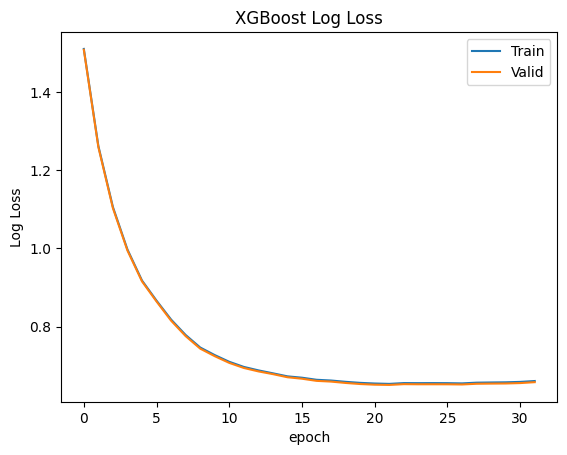

In [84]:
from matplotlib import pyplot as plt

# retrieve performance metrics
results = model_SAMPLE.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots() #plt.subplots(nrows, ncols), it creates a grid of subplots with nrows rows and ncols columns.
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Valid')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('epoch')
plt.title('XGBoost Log Loss')
plt.show()

In [82]:
train_Acc=model_SAMPLE.score(X_train_,y_train_)
print(train_Acc)

0.7510997312830517


In [83]:
test_Acc=model_SAMPLE.score(X_test_2,y_test_2)
print(test_Acc)

0.7502794160634145


**Process 2( with 5-fold cross validation, with small dataset)**

In [85]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [86]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions
# "kwargs" is a common abbreviation for "keyword arguments."

from tqdm import tqdm
train = np.array(encoded_X_train)
target_train = np.array(y_train)
# early_stop = xgboost.callback.EarlyStopping(rounds=2,save_best=True)
test = np.array(encoded_X_test)


test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(encoded_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    xgb_params = study.best_trial.params

    model_xb = xgboost.XGBRegressor(**xgb_params)
    model_xb.fit(train_X, train_y,eval_set=[(valid_X,valid_y)],early_stopping_rounds=10,verbose=True)
    # for train accuracy
    preds = model_xb.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model_xb.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-rmse:1.58830
[1]	validation_0-rmse:1.31816
[2]	validation_0-rmse:1.15304
[3]	validation_0-rmse:1.06434
[4]	validation_0-rmse:1.01365
[5]	validation_0-rmse:0.98331
[6]	validation_0-rmse:0.96453
[7]	validation_0-rmse:0.95442
[8]	validation_0-rmse:0.94657
[9]	validation_0-rmse:0.94416
[10]	validation_0-rmse:0.94272
[11]	validation_0-rmse:0.94179
[12]	validation_0-rmse:0.94045
[13]	validation_0-rmse:0.93893
[14]	validation_0-rmse:0.93909
[15]	validation_0-rmse:0.93739
[16]	validation_0-rmse:0.93681
[17]	validation_0-rmse:0.93664
[18]	validation_0-rmse:0.93665
[19]	validation_0-rmse:0.93649
[20]	validation_0-rmse:0.93702
[21]	validation_0-rmse:0.93690
[22]	validation_0-rmse:0.93708
[23]	validation_0-rmse:0.93660
[24]	validation_0-rmse:0.93650
[25]	validation_0-rmse:0.93643
[26]	validation_0-rmse:0.93664
[27]	validation_0-rmse:0.93689
[28]	validation_0-rmse:0.93668
[29]	validation_0-rmse:0.93680
[30]	validation_0-rmse:0.93669
[31]	validation_0-rmse:0.93672
[32]	validation_0-

 20%|██        | 1/5 [00:30<02:03, 30.94s/it]

[0]	validation_0-rmse:1.59378
[1]	validation_0-rmse:1.33279
[2]	validation_0-rmse:1.17928
[3]	validation_0-rmse:1.09498
[4]	validation_0-rmse:1.04470
[5]	validation_0-rmse:1.01745
[6]	validation_0-rmse:1.00087
[7]	validation_0-rmse:0.99321
[8]	validation_0-rmse:0.98912
[9]	validation_0-rmse:0.98581
[10]	validation_0-rmse:0.98147
[11]	validation_0-rmse:0.97974
[12]	validation_0-rmse:0.97841
[13]	validation_0-rmse:0.97829
[14]	validation_0-rmse:0.97706
[15]	validation_0-rmse:0.97636
[16]	validation_0-rmse:0.97600
[17]	validation_0-rmse:0.97554
[18]	validation_0-rmse:0.97561
[19]	validation_0-rmse:0.97523
[20]	validation_0-rmse:0.97521
[21]	validation_0-rmse:0.97535
[22]	validation_0-rmse:0.97502
[23]	validation_0-rmse:0.97464
[24]	validation_0-rmse:0.97453
[25]	validation_0-rmse:0.97440
[26]	validation_0-rmse:0.97453
[27]	validation_0-rmse:0.97451
[28]	validation_0-rmse:0.97429
[29]	validation_0-rmse:0.97437
[30]	validation_0-rmse:0.97441
[31]	validation_0-rmse:0.97444
[32]	validation_0-

 40%|████      | 2/5 [00:59<01:28, 29.39s/it]

[0]	validation_0-rmse:1.57213
[1]	validation_0-rmse:1.30198
[2]	validation_0-rmse:1.14400
[3]	validation_0-rmse:1.05341
[4]	validation_0-rmse:1.00039
[5]	validation_0-rmse:0.97414
[6]	validation_0-rmse:0.95944
[7]	validation_0-rmse:0.95341
[8]	validation_0-rmse:0.94938
[9]	validation_0-rmse:0.94844
[10]	validation_0-rmse:0.94822
[11]	validation_0-rmse:0.94820
[12]	validation_0-rmse:0.94823
[13]	validation_0-rmse:0.94677
[14]	validation_0-rmse:0.94627
[15]	validation_0-rmse:0.94562
[16]	validation_0-rmse:0.94450
[17]	validation_0-rmse:0.94417
[18]	validation_0-rmse:0.94420
[19]	validation_0-rmse:0.94394
[20]	validation_0-rmse:0.94400
[21]	validation_0-rmse:0.94383
[22]	validation_0-rmse:0.94379
[23]	validation_0-rmse:0.94350
[24]	validation_0-rmse:0.94326
[25]	validation_0-rmse:0.94302
[26]	validation_0-rmse:0.94298
[27]	validation_0-rmse:0.94299
[28]	validation_0-rmse:0.94319
[29]	validation_0-rmse:0.94323
[30]	validation_0-rmse:0.94317
[31]	validation_0-rmse:0.94310
[32]	validation_0-

 60%|██████    | 3/5 [01:26<00:56, 28.28s/it]

[0]	validation_0-rmse:1.58112
[1]	validation_0-rmse:1.31525
[2]	validation_0-rmse:1.15368
[3]	validation_0-rmse:1.06629
[4]	validation_0-rmse:1.01965
[5]	validation_0-rmse:0.99024
[6]	validation_0-rmse:0.97364
[7]	validation_0-rmse:0.97027
[8]	validation_0-rmse:0.96351
[9]	validation_0-rmse:0.95994
[10]	validation_0-rmse:0.95969
[11]	validation_0-rmse:0.95856
[12]	validation_0-rmse:0.95915
[13]	validation_0-rmse:0.95851
[14]	validation_0-rmse:0.95786
[15]	validation_0-rmse:0.95721
[16]	validation_0-rmse:0.95692
[17]	validation_0-rmse:0.95602
[18]	validation_0-rmse:0.95583
[19]	validation_0-rmse:0.95555
[20]	validation_0-rmse:0.95524
[21]	validation_0-rmse:0.95498
[22]	validation_0-rmse:0.95519
[23]	validation_0-rmse:0.95502
[24]	validation_0-rmse:0.95484
[25]	validation_0-rmse:0.95468
[26]	validation_0-rmse:0.95429
[27]	validation_0-rmse:0.95406
[28]	validation_0-rmse:0.95388
[29]	validation_0-rmse:0.95385
[30]	validation_0-rmse:0.95370
[31]	validation_0-rmse:0.95382
[32]	validation_0-

 80%|████████  | 4/5 [01:52<00:27, 27.68s/it]

[0]	validation_0-rmse:1.55730
[1]	validation_0-rmse:1.29391
[2]	validation_0-rmse:1.13436
[3]	validation_0-rmse:1.04304
[4]	validation_0-rmse:0.99935
[5]	validation_0-rmse:0.97079
[6]	validation_0-rmse:0.95767
[7]	validation_0-rmse:0.95110
[8]	validation_0-rmse:0.94687
[9]	validation_0-rmse:0.94481
[10]	validation_0-rmse:0.94437
[11]	validation_0-rmse:0.94382
[12]	validation_0-rmse:0.94347
[13]	validation_0-rmse:0.94267
[14]	validation_0-rmse:0.94128
[15]	validation_0-rmse:0.94115
[16]	validation_0-rmse:0.94005
[17]	validation_0-rmse:0.93950
[18]	validation_0-rmse:0.93945
[19]	validation_0-rmse:0.93947
[20]	validation_0-rmse:0.93924
[21]	validation_0-rmse:0.93948
[22]	validation_0-rmse:0.93930
[23]	validation_0-rmse:0.93918
[24]	validation_0-rmse:0.93909
[25]	validation_0-rmse:0.93902
[26]	validation_0-rmse:0.93893
[27]	validation_0-rmse:0.93894
[28]	validation_0-rmse:0.93897
[29]	validation_0-rmse:0.93897
[30]	validation_0-rmse:0.93909
[31]	validation_0-rmse:0.93912
[32]	validation_0-

100%|██████████| 5/5 [02:23<00:00, 28.66s/it]

0.5983332802768522


In [87]:
#validation accuracy
# target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score


valid_Acc=accuracy_score(target_train,oof_preds.round())
print(valid_Acc)

0.6168628808864266


In [88]:
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_xb=accuracy_score(target_test,test_preds.round())
print(test_Acc_xb)

0.6643871646501841


In [89]:
# train accuracy
train_Acc=model_xb.score(encoded_X_train,y_train)
print(train_Acc)

0.9557685012655562


In [91]:
# test_accuracy
test_Acc=model_xb.score(encoded_X_test,y_test)
print(test_Acc)

0.7823088907293867


# Evaluation

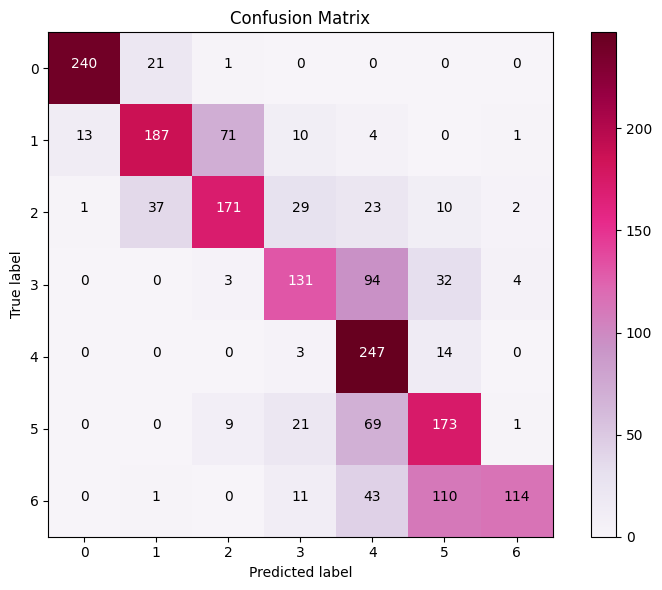

In [41]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
